In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

In [16]:
random_seed = 42
batch_size = 512
epochs = 40
learning_rate = 1e-4
num_classes = 10
patch_size = 4
img_size = 28
in_channels = 1
num_heads = 8
dropout = 0.001
adam_weight_decay = 0
adam_betas = (0.9, 0.999)
num_encoders = 4
embed_dim = (patch_size ** 2) * in_channels # 16
num_patches = (img_size // patch_size) ** 2 # 49

# Expansion of the MLP
expansion = 128

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"


In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            # We use conv instead of linear for efficiency
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                # if kernel_size = stride -> no overlap
                kernel_size=patch_size,
                stride=patch_size
            ),
            # Linear projection of Flattened Patches. We keep the batch and we channels (b,c,h,w)
            nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Create a copy of the cls token for each of the elements of the BATCH
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        # Create the patches
        x = self.patcher(x).permute(0, 2, 1)
        # Unify the position with the patches
        x = torch.cat([cls_token, x], dim=1)
        # Patch + Position Embedding
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

patchemb = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels).to(device)
x = torch.randn(512, 1, 28, 28).to(device)

In [18]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads, dropout=0.1):
    super().__init__()
    self.attn=nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
    self.norm=nn.LayerNorm(embed_dim)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x):
    x=x.transpose(0, 1) #req_by_multi_head_Attention
    attn_output, _ = self.attn(x, x, x)
    x=x+self.dropout(attn_output)
    x=x.transpose(0, 1)
    return self.norm(x)

In [19]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, expansion=4, dropout=0.1):
    super().__init__()
    self.attention=MultiHeadSelfAttention(embed_dim, num_heads, dropout)
    self.mlp=MLP(embed_dim, expansion, dropout)
    self.norm1=nn.LayerNorm(embed_dim)
    self.norm2=nn.LayerNorm(embed_dim)
  def forward(self, x):
    x=x+self.attention(x)
    x=self.norm1(x)
    x=x+self.mlp(x)
    x=self.norm2(x)
    return self.norm(x)

In [20]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, num_layers, expansion=4, dropout=0.1):
    super().__init__()
    self.patch_embed=PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    self.cls_token=nn.Parameter(torch.zeros(1, 1, embed_dim)) #class_token
    self.pos_embed=nn.Parameter(torch.zeros(1, self.patch_embed.n_patches+1, embed_dim)) #positional_embedding

    self.transformer_encoders=nn.ModuleList(
        [TransformerEncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_layers)]
    )

    self.mlp_head=nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, num_classes)
    )

  def forward(self, x):
    batch_size=x.shape[0]
    x=self.patch_embed(x) #(batch_size, n_patches, embed_dim)

    cls_token=self.cls_token.expand(batch_size, -1, -1) #(batch_size, 1, embed_dim)
    x=torch.cat((cls_token, x), dim=1) #add_class_token_to_patch_embeddings

    x=x+self.pos_embed #add_positional_embedding
    for layer in self.transformer_encoders:
      x=layer(x)


    cls_output=x[:, 0]
    return self.mlp_head(cls_output)

In [21]:
#from_scratch_(using nn.MultiheadAttention)_to_explore_the_nature_of_this_component

class MLP(nn.Module):
  def __init__(self, embed_dim, expansion, dropout):
    super().__init__()
    self.fc1=nn.Linear(embed_dim, embed_dim*expansion)
    self.gelu=nn.GELU()
    self.dropout1=nn.Dropout(dropout)
    self.fc2=nn.Linear(embed_dim*expansion, embed_dim)
    self.dropout2=nn.Dropout(dropout)
  def forward(self, x):
    x=self.fc1(x)
    x=self.gelu(x)
    x=self.dropout1(x)
    x=self.fc2(x)
    x=self.dropout2(x)
    return x
    #x=self.fc2(self.dropout1(self.gelu(self.fc1(x))))
    #return self.dropout2(x)

In [22]:
#MultiheadAttention_to_normalized_value_add_resulting_output_original_value_(without normalization)_forms_first_skip_connection
#then_take_output_from_first_step_pass_it_to_normalise_through_MLP_add_this_result_to_original_output_from_first_step_create_second_skip_connection
#after_each_skip_connection_dropout_is_applied

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, expansion, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.MHA = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, expansion, dropout)


    def forward(self, x):
        norm1 = self.norm1(x)
        # Skip connection 1
        x = x + self.MHA(norm1, norm1, norm1)[0]
        x = self.dropout(x)

        norm2 = self.norm2(x)
        # Skip connection 2
        x = x + self.mlp(norm2)
        x = self.dropout(x)

        return x


In [23]:
#for_Transformer_Encoder_blocks_in_Series

class TransformerEncoder(nn.Sequential):
  def __init__(self, embed_dim, num_heads, expansion, dropout, num_encoders):
    super().__init__(*[
        TransformerEncoderLayer(embed_dim, num_heads, expansion, dropout)
        for _ in range(num_encoders)
    ])

In [24]:
#for_better_understanding
class TransformerEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, expansion, dropout, num_encoders):
    super().__init__()
    self.layers=nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, expansion, dropout) for _ in range(num_encoders)])
  def forward(self, x):
    for layer in self.layers:
      x=layer(x)
    return x

In [25]:
class ViT_scratch_without_MHA(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes):
        super().__init__()
        self.embedded_patches = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        self.transformer_encoder =  TransformerEncoder(embed_dim, num_heads, expansion, dropout, num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedded_patches(x)
        x = self.transformer_encoder(x)
        x = self.mlp_head(x[:,0,:])
        return x

In [26]:
model2 = ViT_scratch_without_MHA(embed_dim, patch_size, num_patches, dropout, in_channels, num_heads, num_encoders, expansion, num_classes).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model2(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


In [27]:
model2

ViT_scratch_without_MHA(
  (embedded_patches): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(4, 4))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (MHA): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout): Dropout(p=0.001, inplace=False)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=16, out_features=2048, bias=True)
          (gelu): GELU(approximate='none')
          (dropout1): Dropout(p=0.001, inplace=False)
          (fc2): Linear(in_features=2048, out_features=16, bias=True)
          (dropout2): Dropout(p=0.001, inplac

In [28]:
import torchvision
!pip install torchinfo
from torchinfo import summary


In [29]:
print("\nSummary of the model 2 is:", summary(model2))


Summary of the model 2 is: ==========================================================================================
Layer (type:depth-idx)                                            Param #
ViT_scratch_without_MHA                                           --
├─PatchEmbedding: 1-1                                             816
│    └─Sequential: 2-1                                            --
│    │    └─Conv2d: 3-1                                           272
│    │    └─Flatten: 3-2                                          --
│    └─Dropout: 2-2                                               --
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-3                                            --
│    │    └─TransformerEncoderLayer: 3-3                          68,752
│    │    └─TransformerEncoderLayer: 3-4                          68,752
│    │    └─TransformerEncoderLayer: 3-5                          68,752
│    │    └─TransformerEncoderLaye

In [30]:
#load_emnist_dataset
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
train_transform=transforms.Compose([
    transforms.RandomRotation(15),#Random_Rotation_for_training_data
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])
val_test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#load_dataset
train_data=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
val_data=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=val_test_transform)
test_data=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_test_transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16006726.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 509637.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4393926.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10589510.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [31]:
train_dataset=Subset(train_data, range(48000))
val_dataset=Subset(val_data, range(48000, len(val_data)))

In [32]:
num_workers=torch.cuda.device_count()*4
num_workers

4

In [33]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [34]:
train_dataloader=DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
val_dataloader=DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
test_dataloader=DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
#training
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model2.parameters(), betas=adam_betas, lr=learning_rate, weight_decay=adam_weight_decay)

In [36]:
import torchvision
from torch import optim, nn
import timeit

epochs=50
print("Showing the first 30 elements of each epoch!")
#save_losses_and_Accuracies_for_plot
train_losses=[]
train_accuracies=[]
val_losses=[]
val_accuracies=[]

#training
start=timeit.default_timer()
for epoch in tqdm(range(epochs), position=0, leave=True):
  model2.train()
  train_labels=[]
  train_preds=[]
  train_running_loss=0
  for idx, (data, target) in enumerate(tqdm(train_dataloader, position=0, leave=True)):
    img=data.float().to(device)
    label=target.type(torch.uint8).to(device)
    optimizer.zero_grad()
    y_pred=model2(img)
    y_pred_label=torch.argmax(y_pred, dim=1)
    train_labels.extend(label.cpu().detach())
    train_preds.extend(y_pred_label.cpu().detach())
    loss=criterion(y_pred, label)
    train_running_loss+=loss.item()
    loss.backward()
    optimizer.step()

  train_loss=train_running_loss/(idx+1)

  #saving_metrics_of_training
  train_accuracy=sum(1 for x, y in zip(train_preds, train_labels) if x==y) / len(train_labels)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  model2.eval()

  #validation
  val_labels=[]
  val_preds=[]
  val_running_loss=0
  with torch.no_grad():
    for idx, (data, target) in enumerate(tqdm(val_dataloader, position=0, leave=True)):
      img=data.float().to(device)
      label=target.type(torch.uint8).to(device)
      y_pred=model2(img)
      y_pred_label=torch.argmax(y_pred, dim=1)
      val_labels.extend(label.cpu().detach())
      val_preds.extend(y_pred_label.cpu().detach())
      loss=criterion(y_pred, label)
      val_running_loss+=loss.item()

  val_loss=val_running_loss / (idx+1)
  #saving_metrics_for_validation
  val_accuracy=sum(1 for x, y in zip(val_preds, val_labels) if x==y) / len(val_labels)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  #show_labels_while_training
  train_labels_array=np.array([y.detach().numpy() for y in train_labels])
  train_preds_array=np.array([y.detach().numpy() for y in train_preds])
  val_labels_array=np.array([y.detach().numpy() for y in val_labels])
  val_preds_array=np.array([y.detach().numpy() for y in val_preds])

  print("*"* 30)
  print(f"Epoch: {epoch+1}")
  print("Training Predictions:", train_preds_array[:30])
  print("Training Labels:", train_labels_array[:30])
  print("Validation Predictions:", val_preds_array[:30])
  print("Validation Labels:", val_labels_array[:30])
  print("-"*30)
  print(f"Train Loss: {train_loss:.4f}")
  print(f"Valid Loss: {val_loss:.4f}")
  print(f"Train Accuracy: {train_accuracy:.4f}")
  print(f"Valid Accuracy: {val_accuracy:.4f}")
  print("*" * 30)

stop=timeit.default_timer()
print(f"Training Time: {stop-start:.2f} s")



Showing the first 30 elements of each epoch!


  2%|▏         | 1/50 [00:28<23:34, 28.87s/it]

******************************
Epoch: 1
Training Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
Training Labels: [6 8 6 9 2 1 8 1 7 9 3 4 5 6 7 7 3 9 1 2 0 6 0 0 3 6 7 7 4 8]
Validation Predictions: [6 6 3 1 3 7 8 1 1 0 3 0 1 1 1 1 1 3 1 3 1 0 1 1 3 1 1 1 3 0]
Validation Labels: [6 2 3 1 5 2 7 7 6 0 3 2 7 2 4 7 1 3 6 3 1 0 5 2 4 2 7 5 2 0]
------------------------------
Train Loss: 2.2212
Valid Loss: 1.8724
Train Accuracy: 0.1709
Valid Accuracy: 0.2894
******************************


  4%|▍         | 2/50 [00:53<21:15, 26.57s/it]

******************************
Epoch: 2
Training Predictions: [3 0 3 3 1 3 8 2 1 1 3 1 3 3 8 7 1 1 3 8 0 1 3 0 7 3 3 3 3 3]
Training Labels: [8 4 4 6 1 5 0 2 4 9 5 1 5 3 3 6 5 9 9 2 0 2 0 0 7 5 3 8 0 8]
Validation Predictions: [3 7 3 9 0 0 8 3 3 6 3 1 3 7 4 3 9 6 4 8 0 3 7 9 1 9 8 7 7 2]
Validation Labels: [8 2 3 9 0 0 8 8 3 6 3 2 5 3 4 0 9 2 4 8 0 3 7 4 9 9 8 7 7 2]
------------------------------
Train Loss: 1.6378
Valid Loss: 1.2987
Train Accuracy: 0.4637
Valid Accuracy: 0.6364
******************************


  6%|▌         | 3/50 [01:14<18:44, 23.92s/it]

******************************
Epoch: 3
Training Predictions: [2 4 3 8 5 1 3 4 8 8 4 9 0 3 0 2 1 0 0 1 4 9 1 8 7 3 1 3 2 9]
Training Labels: [2 4 5 5 9 8 8 9 8 8 4 6 0 5 0 2 1 0 0 1 4 9 5 8 2 3 1 3 2 9]
Validation Predictions: [7 7 3 2 8 5 1 2 8 9 6 4 9 0 9 9 6 4 3 9 9 2 4 8 4 4 5 8 3 0]
Validation Labels: [3 9 5 2 8 5 1 2 8 4 6 4 4 0 4 9 6 4 8 4 9 2 4 8 4 9 5 8 0 0]
------------------------------
Train Loss: 1.3178
Valid Loss: 1.0923
Train Accuracy: 0.6251
Valid Accuracy: 0.7292
******************************


  8%|▊         | 4/50 [01:35<17:18, 22.58s/it]

******************************
Epoch: 4
Training Predictions: [2 5 7 7 2 7 9 6 2 1 1 0 6 6 3 3 2 7 3 1 1 8 2 1 7 6 2 7 6 0]
Training Labels: [2 0 7 7 2 7 9 2 3 6 1 0 6 6 8 3 2 7 5 1 7 2 6 1 7 6 2 7 6 7]
Validation Predictions: [2 7 5 3 1 0 0 2 7 1 1 4 2 7 1 1 1 1 2 9 9 0 2 6 5 6 2 3 8 6]
Validation Labels: [2 7 5 3 1 0 3 2 7 5 1 4 2 7 1 1 1 1 2 9 4 0 8 6 5 6 2 5 8 6]
------------------------------
Train Loss: 1.1396
Valid Loss: 0.9427
Train Accuracy: 0.6994
Valid Accuracy: 0.7944
******************************


 10%|█         | 5/50 [01:57<16:52, 22.49s/it]

******************************
Epoch: 5
Training Predictions: [7 6 6 7 2 6 5 0 9 8 2 6 0 8 2 6 7 7 8 5 4 5 3 6 3 6 4 4 7 4]
Training Labels: [3 0 6 7 2 2 3 3 9 7 2 6 0 8 2 6 7 7 8 5 4 3 3 6 3 6 4 4 7 4]
Validation Predictions: [3 1 0 2 6 6 8 3 1 5 8 3 7 1 0 6 5 0 8 8 4 7 4 3 6 5 3 3 9 4]
Validation Labels: [3 1 0 2 6 6 8 3 1 5 8 3 7 7 0 6 5 0 8 8 9 7 4 3 6 5 3 5 9 4]
------------------------------
Train Loss: 1.0115
Valid Loss: 0.8481
Train Accuracy: 0.7449
Valid Accuracy: 0.8155
******************************


 12%|█▏        | 6/50 [02:17<15:56, 21.73s/it]

******************************
Epoch: 6
Training Predictions: [4 2 3 8 7 7 3 3 5 4 4 0 7 0 0 1 7 6 3 1 1 2 1 6 8 8 0 7 8 7]
Training Labels: [4 2 3 8 7 7 3 3 5 9 9 0 7 0 0 1 7 6 3 1 1 2 1 6 2 4 0 7 8 7]
Validation Predictions: [3 4 0 1 1 6 1 6 8 8 7 8 0 8 3 0 5 1 6 7 9 6 4 7 1 2 3 3 7 7]
Validation Labels: [5 4 0 1 1 6 1 6 8 2 7 8 0 8 3 0 5 1 6 1 9 6 4 7 1 2 3 5 7 7]
------------------------------
Train Loss: 0.9131
Valid Loss: 0.7745
Train Accuracy: 0.7757
Valid Accuracy: 0.8250
******************************


 14%|█▍        | 7/50 [02:38<15:21, 21.43s/it]

******************************
Epoch: 7
Training Predictions: [2 6 0 7 8 7 3 1 6 0 6 4 3 2 2 3 9 3 3 2 7 5 5 7 0 4 0 4 1 8]
Training Labels: [3 6 0 2 8 7 5 1 6 4 6 4 3 2 2 8 4 3 3 5 7 6 0 7 0 4 0 4 1 8]
Validation Predictions: [2 2 1 7 7 2 4 8 5 1 4 3 4 1 7 8 8 8 7 0 9 0 3 1 9 1 4 6 1 3]
Validation Labels: [2 2 1 7 7 2 4 8 5 1 4 3 4 1 7 8 8 8 7 0 9 0 5 1 9 1 4 6 1 3]
------------------------------
Train Loss: 0.8275
Valid Loss: 0.6824
Train Accuracy: 0.7973
Valid Accuracy: 0.8521
******************************


 16%|█▌        | 8/50 [03:00<15:11, 21.69s/it]

******************************
Epoch: 8
Training Predictions: [1 2 7 4 7 0 1 4 6 3 1 7 9 6 7 7 1 3 4 8 7 4 5 9 8 8 1 2 9 2]
Training Labels: [1 2 7 9 7 0 1 4 6 3 1 7 9 6 7 7 1 3 4 8 7 9 5 9 8 8 9 2 9 5]
Validation Predictions: [0 3 1 9 7 0 2 8 1 7 3 1 1 8 7 5 9 3 1 4 7 0 0 2 4 0 1 0 4 9]
Validation Labels: [0 3 1 9 7 0 3 8 1 7 8 1 1 8 7 5 7 3 1 4 7 0 0 2 4 0 1 0 4 0]
------------------------------
Train Loss: 0.7566
Valid Loss: 0.6156
Train Accuracy: 0.8169
Valid Accuracy: 0.8714
******************************


 18%|█▊        | 9/50 [03:21<14:42, 21.53s/it]

******************************
Epoch: 9
Training Predictions: [6 8 5 8 1 9 9 3 3 1 3 9 6 0 9 5 6 8 3 7 0 0 7 2 4 2 1 7 2 7]
Training Labels: [6 8 5 5 1 9 9 5 3 1 3 9 6 0 9 5 6 8 8 7 0 0 7 2 4 2 1 7 2 7]
Validation Predictions: [1 1 5 0 1 8 4 3 9 2 6 4 4 9 0 8 1 0 6 5 6 4 4 6 0 8 6 3 5 6]
Validation Labels: [1 5 5 5 1 8 4 3 9 2 6 4 2 9 3 8 1 0 5 5 6 4 4 6 5 8 6 3 5 6]
------------------------------
Train Loss: 0.6980
Valid Loss: 0.5579
Train Accuracy: 0.8295
Valid Accuracy: 0.8842
******************************


 20%|██        | 10/50 [03:42<14:12, 21.30s/it]

******************************
Epoch: 10
Training Predictions: [8 3 9 0 4 2 0 4 7 6 5 0 6 6 2 2 5 7 3 2 2 0 0 6 8 3 6 0 5 2]
Training Labels: [3 3 9 0 4 2 0 9 7 6 5 0 6 6 2 2 5 7 9 2 2 0 0 6 8 3 6 0 3 2]
Validation Predictions: [9 3 3 1 8 4 8 2 5 8 3 7 9 3 1 6 6 7 4 4 5 4 0 3 5 5 3 2 6 2]
Validation Labels: [9 5 3 1 8 4 1 2 5 8 3 7 4 5 1 6 8 7 4 4 5 9 0 3 5 5 3 2 6 2]
------------------------------
Train Loss: 0.6533
Valid Loss: 0.5373
Train Accuracy: 0.8371
Valid Accuracy: 0.8817
******************************


 22%|██▏       | 11/50 [04:04<13:56, 21.44s/it]

******************************
Epoch: 11
Training Predictions: [1 2 1 2 5 5 3 6 5 2 5 4 4 0 6 8 9 8 4 6 0 7 1 9 8 0 3 7 3 1]
Training Labels: [1 2 1 2 8 5 3 6 5 2 5 4 4 3 6 8 9 3 4 6 0 7 1 9 8 0 3 7 7 1]
Validation Predictions: [8 1 6 1 5 9 0 7 3 4 6 2 6 9 9 3 7 8 0 3 4 3 1 8 4 7 1 9 3 1]
Validation Labels: [8 1 6 1 2 9 0 7 3 4 6 2 6 9 9 3 7 8 0 8 4 3 1 8 4 7 1 9 3 1]
------------------------------
Train Loss: 0.5980
Valid Loss: 0.4676
Train Accuracy: 0.8540
Valid Accuracy: 0.9014
******************************


 24%|██▍       | 12/50 [04:24<13:18, 21.02s/it]

******************************
Epoch: 12
Training Predictions: [0 1 8 4 5 3 9 2 7 1 6 1 2 2 0 2 4 6 2 9 4 6 6 7 7 8 4 6 0 4]
Training Labels: [3 1 8 4 6 3 9 6 7 1 6 1 2 3 0 2 4 6 2 9 4 6 6 7 7 8 4 6 0 9]
Validation Predictions: [4 4 2 3 5 1 1 6 8 8 9 9 5 5 7 7 5 2 0 9 9 8 1 2 2 6 1 8 8 1]
Validation Labels: [9 4 2 3 5 1 1 6 8 8 9 9 5 5 7 2 5 2 0 9 9 8 1 2 2 6 1 8 8 1]
------------------------------
Train Loss: 0.5481
Valid Loss: 0.4384
Train Accuracy: 0.8664
Valid Accuracy: 0.9089
******************************


 26%|██▌       | 13/50 [04:45<12:53, 20.90s/it]

******************************
Epoch: 13
Training Predictions: [9 4 1 5 1 2 6 7 4 2 6 3 9 5 4 1 6 4 2 3 6 0 4 2 0 6 8 3 5 1]
Training Labels: [9 4 1 5 1 2 6 7 4 2 6 3 9 5 4 1 6 4 2 3 6 5 4 2 5 6 8 3 5 1]
Validation Predictions: [4 2 1 9 9 4 2 9 8 1 8 8 7 2 0 5 5 1 7 5 2 7 5 3 3 5 6 2 0 4]
Validation Labels: [4 2 1 9 9 4 2 9 8 1 8 8 7 2 0 5 5 1 7 5 2 7 5 3 3 2 6 2 0 4]
------------------------------
Train Loss: 0.5107
Valid Loss: 0.3912
Train Accuracy: 0.8746
Valid Accuracy: 0.9181
******************************


 28%|██▊       | 14/50 [05:06<12:41, 21.14s/it]

******************************
Epoch: 14
Training Predictions: [4 3 2 5 2 5 5 3 3 1 9 5 2 8 5 8 0 3 5 7 2 2 0 0 3 0 8 6 7 5]
Training Labels: [4 3 3 5 2 5 5 3 3 1 4 5 2 8 5 8 0 3 5 7 2 2 0 0 3 0 2 6 7 5]
Validation Predictions: [7 2 3 0 7 2 1 1 7 8 5 5 9 6 9 6 9 6 6 6 2 1 7 2 1 5 2 3 2 7]
Validation Labels: [7 2 3 0 7 0 1 1 7 8 5 5 9 6 9 6 3 6 6 6 2 1 7 2 7 5 2 3 2 9]
------------------------------
Train Loss: 0.4771
Valid Loss: 0.3799
Train Accuracy: 0.8829
Valid Accuracy: 0.9163
******************************


 30%|███       | 15/50 [05:27<12:12, 20.93s/it]

******************************
Epoch: 15
Training Predictions: [8 4 4 2 1 6 5 4 2 8 3 0 6 5 7 5 5 3 0 6 4 8 7 5 8 5 6 4 8 3]
Training Labels: [8 4 4 2 1 6 5 9 2 8 3 0 6 5 7 1 5 3 0 6 4 8 7 5 8 5 6 4 8 3]
Validation Predictions: [9 9 0 0 9 8 8 8 3 5 6 8 6 8 6 7 3 0 8 8 5 6 0 6 3 5 0 7 6 9]
Validation Labels: [9 9 0 0 9 8 8 8 3 5 6 3 6 8 6 7 3 0 8 8 5 6 0 6 3 5 0 7 6 9]
------------------------------
Train Loss: 0.4477
Valid Loss: 0.3536
Train Accuracy: 0.8884
Valid Accuracy: 0.9212
******************************


 32%|███▏      | 16/50 [05:47<11:46, 20.78s/it]

******************************
Epoch: 16
Training Predictions: [4 4 6 6 7 9 9 4 2 9 7 2 2 3 1 5 7 9 7 9 7 9 4 1 0 7 0 1 0 0]
Training Labels: [4 4 6 4 7 9 9 4 2 9 7 2 2 3 1 5 7 4 7 9 7 9 4 1 0 7 0 1 0 0]
Validation Predictions: [6 4 0 1 8 6 7 0 5 4 7 1 1 8 2 3 9 4 3 1 9 5 1 7 3 4 3 6 6 0]
Validation Labels: [0 4 0 1 8 6 7 0 5 4 7 1 1 8 2 3 9 4 3 1 9 5 1 7 3 4 3 6 6 0]
------------------------------
Train Loss: 0.4256
Valid Loss: 0.3246
Train Accuracy: 0.8918
Valid Accuracy: 0.9267
******************************


 34%|███▍      | 17/50 [06:09<11:33, 21.02s/it]

******************************
Epoch: 17
Training Predictions: [9 7 5 7 0 3 6 1 1 2 7 4 2 6 0 8 3 9 9 8 4 3 3 1 7 5 4 0 5 2]
Training Labels: [4 7 5 7 0 3 6 1 1 3 7 4 2 6 0 8 3 7 9 8 4 3 3 1 7 5 4 0 5 7]
Validation Predictions: [2 0 3 1 8 8 9 6 3 7 2 3 7 0 6 9 9 7 3 2 4 6 9 8 6 3 0 6 2 3]
Validation Labels: [2 0 3 1 8 8 9 6 5 7 2 3 8 0 6 9 9 7 3 2 4 6 9 8 6 3 0 6 2 3]
------------------------------
Train Loss: 0.4000
Valid Loss: 0.3078
Train Accuracy: 0.8984
Valid Accuracy: 0.9282
******************************


 36%|███▌      | 18/50 [06:29<11:07, 20.85s/it]

******************************
Epoch: 18
Training Predictions: [2 2 1 4 1 6 3 6 3 9 2 9 1 1 4 5 5 0 1 6 9 9 8 6 7 3 2 1 8 8]
Training Labels: [2 2 1 4 1 6 3 6 3 8 2 9 1 1 4 5 9 6 1 6 9 9 8 6 7 3 2 1 8 8]
Validation Predictions: [8 6 5 8 8 3 9 9 7 7 2 8 6 3 2 9 2 1 4 2 9 1 8 2 9 8 7 4 6 2]
Validation Labels: [8 6 5 8 8 3 9 9 7 7 2 8 6 5 2 9 3 1 4 2 9 1 8 2 9 8 7 4 6 2]
------------------------------
Train Loss: 0.3818
Valid Loss: 0.2816
Train Accuracy: 0.9029
Valid Accuracy: 0.9363
******************************


 38%|███▊      | 19/50 [06:50<10:42, 20.74s/it]

******************************
Epoch: 19
Training Predictions: [7 1 7 8 2 3 4 2 6 4 4 5 8 1 1 4 8 6 2 1 0 8 7 5 7 9 9 2 8 2]
Training Labels: [7 1 7 8 2 3 4 3 6 4 3 5 8 1 1 4 8 6 2 1 0 8 7 5 7 9 9 2 2 2]
Validation Predictions: [4 4 9 0 6 5 4 0 3 0 5 7 0 5 6 9 1 1 5 4 9 9 5 2 7 7 4 6 8 9]
Validation Labels: [4 4 9 0 6 5 4 0 3 0 5 7 0 5 6 9 1 1 5 4 9 9 9 2 7 7 4 6 8 9]
------------------------------
Train Loss: 0.3655
Valid Loss: 0.2744
Train Accuracy: 0.9052
Valid Accuracy: 0.9359
******************************


 40%|████      | 20/50 [07:11<10:27, 20.93s/it]

******************************
Epoch: 20
Training Predictions: [0 5 3 5 4 3 2 1 0 8 4 8 5 4 2 9 9 4 2 2 8 4 9 9 1 9 8 3 8 7]
Training Labels: [0 3 3 5 4 3 2 1 0 8 4 8 0 4 2 9 9 4 2 2 8 4 9 9 1 9 8 3 8 7]
Validation Predictions: [8 6 1 0 9 6 8 3 2 7 9 2 5 1 5 1 9 1 1 8 4 1 3 2 9 3 3 0 1 5]
Validation Labels: [8 6 1 0 9 6 8 3 2 7 9 2 5 1 5 1 9 1 1 8 4 1 3 2 9 3 3 0 1 5]
------------------------------
Train Loss: 0.3500
Valid Loss: 0.2727
Train Accuracy: 0.9070
Valid Accuracy: 0.9339
******************************


 42%|████▏     | 21/50 [07:32<10:01, 20.76s/it]

******************************
Epoch: 21
Training Predictions: [2 7 7 1 2 8 0 1 6 4 8 4 0 4 3 7 2 7 2 4 1 5 4 4 0 3 1 6 5 5]
Training Labels: [2 7 7 1 2 8 0 1 6 4 8 4 0 4 5 7 2 7 2 4 1 5 4 4 0 3 1 6 5 5]
Validation Predictions: [4 6 1 5 0 0 4 2 4 7 1 5 0 2 3 3 4 7 7 1 2 4 5 5 0 4 6 4 2 1]
Validation Labels: [4 6 1 5 0 0 4 2 4 7 1 3 0 2 3 3 4 7 7 1 2 4 5 5 0 4 6 4 2 1]
------------------------------
Train Loss: 0.3428
Valid Loss: 0.2508
Train Accuracy: 0.9087
Valid Accuracy: 0.9407
******************************


 44%|████▍     | 22/50 [07:52<09:36, 20.59s/it]

******************************
Epoch: 22
Training Predictions: [7 9 2 4 3 6 6 8 5 9 0 3 9 5 1 7 8 5 6 2 0 0 8 6 3 7 5 8 0 7]
Training Labels: [7 9 2 4 3 6 6 8 5 9 0 3 9 5 1 7 2 3 8 2 0 0 8 6 3 7 5 8 0 7]
Validation Predictions: [9 0 8 9 0 5 1 5 6 3 6 6 8 6 4 8 7 2 7 1 8 2 8 2 3 0 6 5 2 1]
Validation Labels: [9 0 8 9 0 5 1 5 6 3 6 6 3 5 4 8 7 1 7 1 8 2 8 2 3 0 6 5 2 1]
------------------------------
Train Loss: 0.3254
Valid Loss: 0.2438
Train Accuracy: 0.9135
Valid Accuracy: 0.9408
******************************


 46%|████▌     | 23/50 [08:13<09:24, 20.89s/it]

******************************
Epoch: 23
Training Predictions: [1 3 0 0 1 5 1 3 0 4 3 1 1 8 1 5 6 3 2 9 2 8 4 5 2 3 3 2 8 5]
Training Labels: [1 3 0 0 1 5 8 3 0 4 3 1 1 8 1 8 6 3 2 9 2 8 4 5 2 3 3 7 4 5]
Validation Predictions: [7 5 0 3 0 3 3 4 2 6 8 9 3 5 7 6 1 1 7 4 6 5 6 5 8 7 2 5 1 7]
Validation Labels: [7 5 0 3 0 3 7 4 2 6 8 9 3 5 7 6 1 1 7 4 2 5 6 5 8 7 2 5 1 7]
------------------------------
Train Loss: 0.3093
Valid Loss: 0.2263
Train Accuracy: 0.9179
Valid Accuracy: 0.9447
******************************


 48%|████▊     | 24/50 [08:33<08:57, 20.68s/it]

******************************
Epoch: 24
Training Predictions: [6 9 5 3 6 8 8 9 4 5 1 6 3 9 5 1 1 0 4 9 1 5 4 3 8 3 5 6 0 9]
Training Labels: [6 9 5 3 6 8 8 9 4 5 1 6 3 9 5 9 1 0 4 9 1 6 4 3 8 3 5 6 0 8]
Validation Predictions: [3 1 7 3 3 6 1 0 1 7 7 3 0 6 1 5 0 8 1 4 1 5 9 2 1 5 9 3 7 9]
Validation Labels: [3 1 7 3 3 6 1 6 1 7 9 3 0 6 1 5 0 8 1 4 1 5 9 2 1 5 9 3 7 9]
------------------------------
Train Loss: 0.2970
Valid Loss: 0.2299
Train Accuracy: 0.9184
Valid Accuracy: 0.9425
******************************


 50%|█████     | 25/50 [08:54<08:34, 20.60s/it]

******************************
Epoch: 25
Training Predictions: [3 5 3 9 2 6 3 6 1 2 9 6 4 7 6 4 3 5 8 3 7 2 2 6 6 8 8 2 6 5]
Training Labels: [3 5 3 4 2 6 3 5 1 2 9 6 4 7 8 9 5 5 8 3 7 2 2 6 6 8 8 2 6 5]
Validation Predictions: [1 0 7 7 4 8 0 2 9 6 7 4 2 1 8 2 1 5 6 6 9 4 9 5 4 6 9 8 6 7]
Validation Labels: [1 0 7 7 4 8 0 3 9 6 7 4 2 1 9 2 1 5 6 6 9 4 9 9 4 6 9 8 6 7]
------------------------------
Train Loss: 0.2938
Valid Loss: 0.2111
Train Accuracy: 0.9196
Valid Accuracy: 0.9474
******************************


 52%|█████▏    | 26/50 [09:16<08:26, 21.10s/it]

******************************
Epoch: 26
Training Predictions: [1 0 7 8 5 1 5 7 2 1 4 8 5 6 6 5 2 2 9 2 5 3 5 7 2 8 6 6 2 8]
Training Labels: [1 0 7 8 5 1 6 7 2 1 4 8 5 2 6 3 0 2 9 2 5 3 5 7 2 8 6 0 2 8]
Validation Predictions: [1 2 0 3 2 9 8 9 5 7 5 4 0 2 8 3 4 6 2 6 6 2 8 0 1 3 3 6 9 3]
Validation Labels: [1 2 0 3 2 9 8 9 5 7 5 4 0 2 8 3 4 6 2 8 6 2 8 0 1 3 3 6 9 3]
------------------------------
Train Loss: 0.2854
Valid Loss: 0.2043
Train Accuracy: 0.9213
Valid Accuracy: 0.9486
******************************


 54%|█████▍    | 27/50 [09:37<08:01, 20.93s/it]

******************************
Epoch: 27
Training Predictions: [6 6 5 6 8 3 7 3 8 0 2 2 5 8 4 3 5 3 6 7 7 8 3 9 4 6 9 6 7 1]
Training Labels: [6 6 5 6 8 3 7 3 8 4 2 5 5 8 4 3 8 3 6 7 4 8 3 7 4 6 9 6 7 1]
Validation Predictions: [1 7 3 1 7 1 7 7 0 6 7 3 8 4 6 8 6 8 0 1 0 6 5 6 1 4 4 6 6 6]
Validation Labels: [1 7 3 1 7 1 7 8 0 6 7 3 8 4 6 8 6 8 0 1 0 6 2 6 1 4 4 6 6 6]
------------------------------
Train Loss: 0.2781
Valid Loss: 0.2149
Train Accuracy: 0.9237
Valid Accuracy: 0.9457
******************************


 56%|█████▌    | 28/50 [09:57<07:37, 20.79s/it]

******************************
Epoch: 28
Training Predictions: [7 0 9 6 1 5 9 2 1 7 2 1 6 3 9 6 6 8 8 6 6 2 9 5 2 5 1 4 8 7]
Training Labels: [7 0 9 6 1 5 9 2 1 7 2 1 6 3 9 6 6 8 8 6 6 2 9 5 2 5 1 4 8 8]
Validation Predictions: [0 1 8 6 0 0 5 8 3 8 9 5 6 3 3 1 6 3 0 4 6 0 8 1 6 0 2 8 7 8]
Validation Labels: [0 1 8 6 0 0 5 8 3 8 9 5 6 3 3 2 6 3 0 4 6 0 8 1 6 0 2 8 7 8]
------------------------------
Train Loss: 0.2686
Valid Loss: 0.1975
Train Accuracy: 0.9257
Valid Accuracy: 0.9497
******************************


 58%|█████▊    | 29/50 [10:18<07:20, 20.95s/it]

******************************
Epoch: 29
Training Predictions: [7 6 5 2 0 2 7 7 0 5 7 2 1 4 1 4 8 8 9 4 9 7 7 1 5 8 5 1 8 9]
Training Labels: [7 6 5 2 0 2 5 7 0 5 7 2 1 4 1 4 8 8 9 4 9 7 7 1 5 8 5 1 8 9]
Validation Predictions: [7 9 7 0 6 9 7 1 7 7 4 4 4 1 3 2 8 2 1 8 8 4 8 9 5 8 9 9 0 9]
Validation Labels: [7 9 7 0 6 9 7 1 7 7 4 4 4 1 3 2 8 2 1 8 8 4 8 9 5 8 4 9 0 9]
------------------------------
Train Loss: 0.2595
Valid Loss: 0.1982
Train Accuracy: 0.9276
Valid Accuracy: 0.9476
******************************


 60%|██████    | 30/50 [10:39<06:55, 20.78s/it]

******************************
Epoch: 30
Training Predictions: [4 6 3 9 9 5 9 0 1 3 2 1 9 3 0 8 5 4 0 9 4 0 9 7 3 4 1 3 5 4]
Training Labels: [4 6 3 9 4 5 9 0 1 3 2 1 9 3 0 8 5 4 0 7 4 0 9 7 3 4 1 3 5 4]
Validation Predictions: [6 6 8 3 0 9 0 6 2 3 3 7 4 9 8 0 7 3 3 3 5 7 7 1 3 6 8 3 2 4]
Validation Labels: [6 6 8 3 0 9 0 6 2 3 3 7 4 9 8 0 7 3 3 3 5 7 7 1 3 6 8 3 2 4]
------------------------------
Train Loss: 0.2504
Valid Loss: 0.1841
Train Accuracy: 0.9306
Valid Accuracy: 0.9527
******************************


 62%|██████▏   | 31/50 [10:59<06:33, 20.73s/it]

******************************
Epoch: 31
Training Predictions: [9 7 6 7 8 8 9 9 7 3 2 1 6 7 6 0 3 9 9 2 5 7 8 9 8 6 4 6 4 2]
Training Labels: [9 7 6 7 8 8 9 9 7 3 2 1 6 3 6 0 3 9 9 2 5 7 8 9 8 5 6 6 4 2]
Validation Predictions: [2 8 1 8 6 6 1 9 1 0 4 6 8 5 0 0 8 2 9 4 6 8 2 0 2 4 8 4 2 2]
Validation Labels: [5 8 1 8 6 6 1 9 1 0 4 6 8 5 0 0 8 2 9 4 6 8 2 0 2 4 8 4 2 2]
------------------------------
Train Loss: 0.2472
Valid Loss: 0.1899
Train Accuracy: 0.9296
Valid Accuracy: 0.9508
******************************


 64%|██████▍   | 32/50 [11:21<06:18, 21.03s/it]

******************************
Epoch: 32
Training Predictions: [2 7 4 1 1 8 2 9 4 5 8 0 6 9 2 4 7 4 2 5 3 0 0 4 3 3 7 9 2 6]
Training Labels: [2 7 4 1 1 8 2 4 4 5 8 0 6 9 2 4 7 4 2 5 3 0 0 4 3 3 7 7 3 6]
Validation Predictions: [5 7 3 2 4 3 0 6 9 3 2 6 8 8 9 5 9 7 3 0 8 6 1 3 9 1 5 7 6 9]
Validation Labels: [5 7 3 5 4 3 0 6 9 3 2 6 8 8 4 5 9 7 9 0 8 6 1 3 9 1 5 7 6 9]
------------------------------
Train Loss: 0.2377
Valid Loss: 0.1753
Train Accuracy: 0.9323
Valid Accuracy: 0.9533
******************************


 66%|██████▌   | 33/50 [11:41<05:52, 20.72s/it]

******************************
Epoch: 33
Training Predictions: [2 9 5 1 6 0 6 2 3 6 1 6 3 1 0 2 2 8 9 3 8 7 0 8 4 1 1 1 1 3]
Training Labels: [2 9 5 1 6 0 6 2 3 6 5 6 3 1 0 2 2 8 9 3 8 3 0 8 4 1 7 1 1 3]
Validation Predictions: [3 1 3 9 9 2 4 1 2 6 2 2 6 9 6 3 9 3 3 7 7 0 9 4 1 8 3 5 3 6]
Validation Labels: [3 1 3 9 9 2 4 1 2 6 2 2 5 9 6 3 9 8 3 7 7 0 9 4 1 8 3 5 3 6]
------------------------------
Train Loss: 0.2365
Valid Loss: 0.1689
Train Accuracy: 0.9323
Valid Accuracy: 0.9547
******************************


 68%|██████▊   | 34/50 [12:02<05:30, 20.64s/it]

******************************
Epoch: 34
Training Predictions: [8 9 3 1 8 0 3 8 9 7 3 1 3 8 2 4 6 9 0 2 8 0 8 0 3 6 2 6 0 0]
Training Labels: [8 9 3 1 8 0 3 8 9 9 3 1 3 8 2 4 6 9 0 2 8 0 8 0 3 6 2 6 0 0]
Validation Predictions: [4 9 5 3 4 8 5 2 9 1 7 7 1 2 9 3 7 4 6 2 3 6 6 9 6 3 7 5 4 7]
Validation Labels: [4 9 5 3 4 8 5 2 9 1 7 7 1 2 9 3 7 4 6 2 3 6 6 9 6 3 7 5 4 7]
------------------------------
Train Loss: 0.2307
Valid Loss: 0.1645
Train Accuracy: 0.9331
Valid Accuracy: 0.9558
******************************


 70%|███████   | 35/50 [12:24<05:16, 21.12s/it]

******************************
Epoch: 35
Training Predictions: [6 2 7 1 4 9 3 0 4 3 8 4 8 1 1 7 9 7 8 9 8 0 3 6 2 8 2 3 7 9]
Training Labels: [6 2 7 1 4 9 3 0 4 3 8 4 8 1 1 2 9 7 8 9 8 0 3 6 2 8 2 3 7 5]
Validation Predictions: [3 4 8 5 2 0 2 2 2 8 4 9 0 7 5 8 2 7 2 3 4 0 5 0 1 4 1 2 9 0]
Validation Labels: [3 4 8 5 2 0 2 2 2 8 4 9 0 7 5 8 2 7 2 3 4 0 5 0 1 4 1 2 9 0]
------------------------------
Train Loss: 0.2224
Valid Loss: 0.1681
Train Accuracy: 0.9363
Valid Accuracy: 0.9547
******************************


 72%|███████▏  | 36/50 [12:45<04:55, 21.08s/it]

******************************
Epoch: 36
Training Predictions: [4 1 7 4 9 0 5 3 9 0 1 1 5 2 9 0 6 2 2 1 2 4 8 5 4 8 1 8 5 3]
Training Labels: [4 2 7 4 9 0 5 3 9 0 1 1 5 2 9 0 6 2 6 1 2 4 8 5 4 5 1 8 5 3]
Validation Predictions: [5 3 7 5 0 4 3 6 9 1 7 4 9 1 2 1 2 4 0 3 2 8 4 2 4 6 9 1 7 4]
Validation Labels: [5 3 7 5 0 4 3 6 9 1 7 4 9 1 3 1 2 4 0 3 2 8 4 2 4 6 9 1 7 4]
------------------------------
Train Loss: 0.2222
Valid Loss: 0.1742
Train Accuracy: 0.9356
Valid Accuracy: 0.9522
******************************


 74%|███████▍  | 37/50 [13:05<04:31, 20.91s/it]

******************************
Epoch: 37
Training Predictions: [0 9 6 5 8 2 9 9 1 5 1 8 7 2 3 3 1 1 2 2 1 4 2 8 1 0 7 9 9 3]
Training Labels: [0 9 6 5 8 2 9 9 1 5 1 8 7 2 3 3 1 1 2 2 1 4 2 8 1 0 7 9 9 3]
Validation Predictions: [7 6 8 5 0 4 3 5 3 8 0 9 6 7 7 0 8 8 5 3 3 9 5 2 3 6 8 2 8 1]
Validation Labels: [7 6 8 5 0 4 8 5 3 8 0 9 6 7 7 0 8 8 5 3 3 9 5 2 3 6 8 2 8 1]
------------------------------
Train Loss: 0.2215
Valid Loss: 0.1601
Train Accuracy: 0.9364
Valid Accuracy: 0.9564
******************************


 76%|███████▌  | 38/50 [13:28<04:15, 21.27s/it]

******************************
Epoch: 38
Training Predictions: [0 7 4 7 6 3 8 0 6 3 7 2 2 2 6 5 2 0 8 5 4 9 6 6 8 0 4 4 4 8]
Training Labels: [0 7 4 7 6 3 8 0 6 3 7 2 2 2 6 5 2 2 8 5 4 9 6 6 8 0 4 4 4 8]
Validation Predictions: [7 3 0 5 2 9 6 8 6 7 8 3 9 1 6 0 3 7 6 8 2 9 2 0 5 6 7 5 5 0]
Validation Labels: [2 8 0 5 2 9 6 8 6 7 8 3 4 1 6 0 3 7 6 5 2 9 2 0 5 6 7 5 5 0]
------------------------------
Train Loss: 0.2114
Valid Loss: 0.1589
Train Accuracy: 0.9376
Valid Accuracy: 0.9557
******************************


 78%|███████▊  | 39/50 [13:48<03:50, 21.00s/it]

******************************
Epoch: 39
Training Predictions: [4 1 9 2 6 6 9 9 5 6 6 4 5 0 2 3 5 9 3 6 2 7 9 5 7 1 8 6 8 3]
Training Labels: [4 1 9 2 6 6 9 9 5 6 6 4 5 0 2 3 3 9 3 6 2 7 4 5 7 1 0 6 8 2]
Validation Predictions: [6 4 1 2 8 2 3 9 6 0 6 0 8 3 8 6 7 1 7 8 8 6 8 5 4 8 9 6 3 9]
Validation Labels: [6 4 1 2 8 2 3 9 6 0 6 0 0 3 8 6 7 1 7 8 8 6 8 5 4 8 9 6 3 9]
------------------------------
Train Loss: 0.2081
Valid Loss: 0.1598
Train Accuracy: 0.9387
Valid Accuracy: 0.9555
******************************


 80%|████████  | 40/50 [14:08<03:28, 20.89s/it]

******************************
Epoch: 40
Training Predictions: [3 2 0 7 0 2 4 7 8 8 4 2 4 4 0 0 7 4 2 9 5 3 2 1 6 7 7 0 5 2]
Training Labels: [3 2 0 7 0 2 4 7 8 8 4 1 4 4 0 0 7 4 2 9 5 3 2 1 6 7 7 0 5 2]
Validation Predictions: [3 7 6 4 5 0 8 5 7 9 7 6 1 9 6 8 3 5 6 4 5 0 3 6 9 3 2 9 8 5]
Validation Labels: [3 7 6 4 2 0 8 5 4 9 7 4 1 9 6 2 3 5 6 4 5 0 3 6 9 3 2 9 8 5]
------------------------------
Train Loss: 0.2062
Valid Loss: 0.1515
Train Accuracy: 0.9391
Valid Accuracy: 0.9577
******************************


 82%|████████▏ | 41/50 [14:31<03:13, 21.47s/it]

******************************
Epoch: 41
Training Predictions: [2 1 8 5 4 2 3 3 1 5 9 5 5 5 2 2 0 6 5 7 1 6 5 7 6 4 6 2 1 1]
Training Labels: [2 1 8 5 4 2 3 3 1 5 9 5 5 5 2 2 0 6 5 3 1 6 5 7 6 4 6 2 1 3]
Validation Predictions: [1 7 1 3 5 4 6 6 2 3 5 4 7 0 6 4 2 4 4 3 3 4 0 1 4 1 8 7 4 8]
Validation Labels: [1 7 1 3 5 4 6 6 2 3 5 4 7 0 6 4 2 4 4 3 3 4 0 1 4 1 8 7 4 8]
------------------------------
Train Loss: 0.2031
Valid Loss: 0.1488
Train Accuracy: 0.9403
Valid Accuracy: 0.9577
******************************


 84%|████████▍ | 42/50 [14:52<02:49, 21.22s/it]

******************************
Epoch: 42
Training Predictions: [7 3 5 1 6 9 8 2 3 7 6 1 6 3 3 4 9 9 7 3 7 0 7 4 2 5 2 4 1 9]
Training Labels: [7 3 5 1 6 9 8 2 3 7 6 1 6 5 3 4 9 9 7 3 7 0 7 4 2 5 2 4 1 9]
Validation Predictions: [1 2 2 3 0 7 2 7 6 8 5 1 7 4 8 8 6 0 5 9 5 8 7 9 4 4 5 5 3 1]
Validation Labels: [1 2 2 3 4 7 2 7 6 8 5 1 7 4 8 8 6 0 5 9 5 8 7 9 4 4 5 5 3 1]
------------------------------
Train Loss: 0.2002
Valid Loss: 0.1417
Train Accuracy: 0.9412
Valid Accuracy: 0.9607
******************************


 86%|████████▌ | 43/50 [15:13<02:28, 21.16s/it]

******************************
Epoch: 43
Training Predictions: [3 5 2 6 9 9 5 6 7 2 3 5 9 5 6 7 6 2 2 4 3 2 4 8 0 7 4 0 6 3]
Training Labels: [3 5 2 6 9 9 5 6 7 2 3 5 9 5 6 7 6 7 2 4 3 2 4 8 0 7 4 0 6 3]
Validation Predictions: [6 7 5 6 0 1 9 0 8 6 1 3 4 8 4 6 1 7 9 3 8 0 7 7 1 1 7 0 8 8]
Validation Labels: [6 7 5 6 0 1 9 0 8 6 1 3 4 8 4 6 1 7 9 3 8 0 7 7 1 1 7 0 8 8]
------------------------------
Train Loss: 0.2004
Valid Loss: 0.1666
Train Accuracy: 0.9410
Valid Accuracy: 0.9542
******************************


 88%|████████▊ | 44/50 [15:35<02:08, 21.40s/it]

******************************
Epoch: 44
Training Predictions: [1 3 9 9 3 6 6 0 0 4 5 8 0 7 4 4 6 1 1 8 3 0 8 6 9 5 3 0 9 4]
Training Labels: [1 3 9 4 3 6 6 0 0 4 5 8 0 7 4 4 6 1 1 8 3 0 8 6 9 5 3 0 9 4]
Validation Predictions: [3 0 7 9 8 5 9 2 5 9 6 7 6 6 9 8 3 9 1 9 7 0 2 1 2 7 1 8 5 5]
Validation Labels: [3 0 7 9 8 5 9 2 5 9 6 7 6 6 9 8 3 9 1 9 7 0 2 1 2 7 1 8 6 5]
------------------------------
Train Loss: 0.1929
Valid Loss: 0.1520
Train Accuracy: 0.9427
Valid Accuracy: 0.9576
******************************


 90%|█████████ | 45/50 [15:56<01:47, 21.40s/it]

******************************
Epoch: 45
Training Predictions: [8 1 9 6 1 6 2 9 2 6 4 8 4 0 5 9 0 1 4 5 2 6 2 2 1 6 3 0 3 5]
Training Labels: [8 1 9 6 1 6 2 9 2 6 4 3 4 0 5 9 0 1 4 3 2 5 2 2 1 6 3 0 3 5]
Validation Predictions: [3 1 3 2 5 4 9 6 5 9 6 0 9 4 8 2 8 5 8 2 7 0 0 8 5 4 7 2 8 1]
Validation Labels: [3 1 3 2 5 4 9 6 5 9 6 0 9 4 8 2 8 5 8 2 7 0 0 8 5 4 7 2 8 1]
------------------------------
Train Loss: 0.1886
Valid Loss: 0.1346
Train Accuracy: 0.9433
Valid Accuracy: 0.9606
******************************


 92%|█████████▏| 46/50 [16:17<01:24, 21.24s/it]

******************************
Epoch: 46
Training Predictions: [8 2 9 0 0 4 4 6 4 5 8 1 9 5 8 3 1 3 5 7 4 4 3 5 6 1 5 1 1 5]
Training Labels: [8 2 9 0 0 4 4 6 4 5 8 1 9 5 8 3 1 3 8 7 4 4 3 5 6 1 5 1 1 5]
Validation Predictions: [2 3 6 9 3 8 0 8 3 4 4 1 8 9 8 7 5 2 4 5 8 1 0 1 4 6 2 6 0 1]
Validation Labels: [2 3 6 9 3 8 0 8 3 4 4 1 8 9 8 7 5 2 4 5 8 1 0 1 4 6 2 6 0 1]
------------------------------
Train Loss: 0.1849
Valid Loss: 0.1349
Train Accuracy: 0.9451
Valid Accuracy: 0.9616
******************************


 94%|█████████▍| 47/50 [16:41<01:05, 21.96s/it]

******************************
Epoch: 47
Training Predictions: [1 7 6 4 4 7 3 3 4 1 6 2 3 2 8 9 6 0 6 7 9 6 7 7 9 0 0 4 4 9]
Training Labels: [1 7 6 4 4 7 3 3 4 1 6 2 3 2 8 9 6 0 6 7 7 6 7 9 9 0 0 4 4 9]
Validation Predictions: [2 0 8 6 4 3 6 9 2 0 2 6 5 1 1 3 0 7 5 1 9 1 3 9 5 0 2 1 6 1]
Validation Labels: [2 0 8 6 4 3 6 9 2 0 2 6 5 1 1 3 0 7 5 1 9 1 3 9 5 0 2 1 6 1]
------------------------------
Train Loss: 0.1865
Valid Loss: 0.1337
Train Accuracy: 0.9442
Valid Accuracy: 0.9623
******************************


 96%|█████████▌| 48/50 [17:02<00:43, 21.76s/it]

******************************
Epoch: 48
Training Predictions: [3 6 0 1 1 0 6 6 0 4 0 8 8 5 2 1 9 8 3 7 9 3 5 0 6 4 1 0 6 1]
Training Labels: [3 6 0 1 1 0 6 6 0 4 0 8 8 5 2 1 9 8 3 7 9 3 5 0 6 4 1 0 6 1]
Validation Predictions: [2 3 2 3 0 9 0 8 0 7 4 7 3 1 1 7 2 8 4 9 8 9 7 5 0 0 5 2 6 2]
Validation Labels: [2 3 2 3 0 9 0 8 0 7 4 7 3 1 1 7 2 8 4 9 8 9 7 5 0 0 5 2 6 2]
------------------------------
Train Loss: 0.1777
Valid Loss: 0.1307
Train Accuracy: 0.9479
Valid Accuracy: 0.9622
******************************


 98%|█████████▊| 49/50 [17:23<00:21, 21.63s/it]

******************************
Epoch: 49
Training Predictions: [2 9 6 7 0 2 2 6 5 3 3 7 5 6 8 4 1 9 3 2 5 1 3 4 6 4 6 2 5 5]
Training Labels: [2 9 6 7 0 7 2 6 5 3 3 7 5 6 8 4 1 9 3 2 8 1 3 4 6 4 6 2 5 5]
Validation Predictions: [8 9 9 6 9 0 4 2 8 8 8 7 9 7 0 1 9 8 1 6 3 9 5 6 6 5 1 7 9 7]
Validation Labels: [8 9 9 6 9 0 4 2 8 8 8 7 9 7 0 1 9 2 1 6 3 9 5 6 6 5 1 7 9 7]
------------------------------
Train Loss: 0.1791
Valid Loss: 0.1369
Train Accuracy: 0.9457
Valid Accuracy: 0.9587
******************************


100%|██████████| 50/50 [17:47<00:00, 21.34s/it]

******************************
Epoch: 50
Training Predictions: [6 8 2 9 5 3 5 8 9 6 5 5 8 1 8 4 3 4 2 2 2 8 6 4 5 9 7 9 3 7]
Training Labels: [6 8 2 9 5 3 5 8 9 6 5 5 8 1 8 4 5 4 2 2 2 8 6 4 5 9 7 9 3 3]
Validation Predictions: [1 5 5 0 2 6 6 6 1 6 6 6 8 5 6 5 9 5 2 0 3 1 8 8 6 9 8 5 5 0]
Validation Labels: [1 5 5 0 2 6 6 6 1 6 6 6 8 5 6 5 9 5 2 0 3 1 8 8 6 9 8 5 5 0]
------------------------------
Train Loss: 0.1775
Valid Loss: 0.1351
Train Accuracy: 0.9469
Valid Accuracy: 0.9615
******************************
Training Time: 1067.14 s


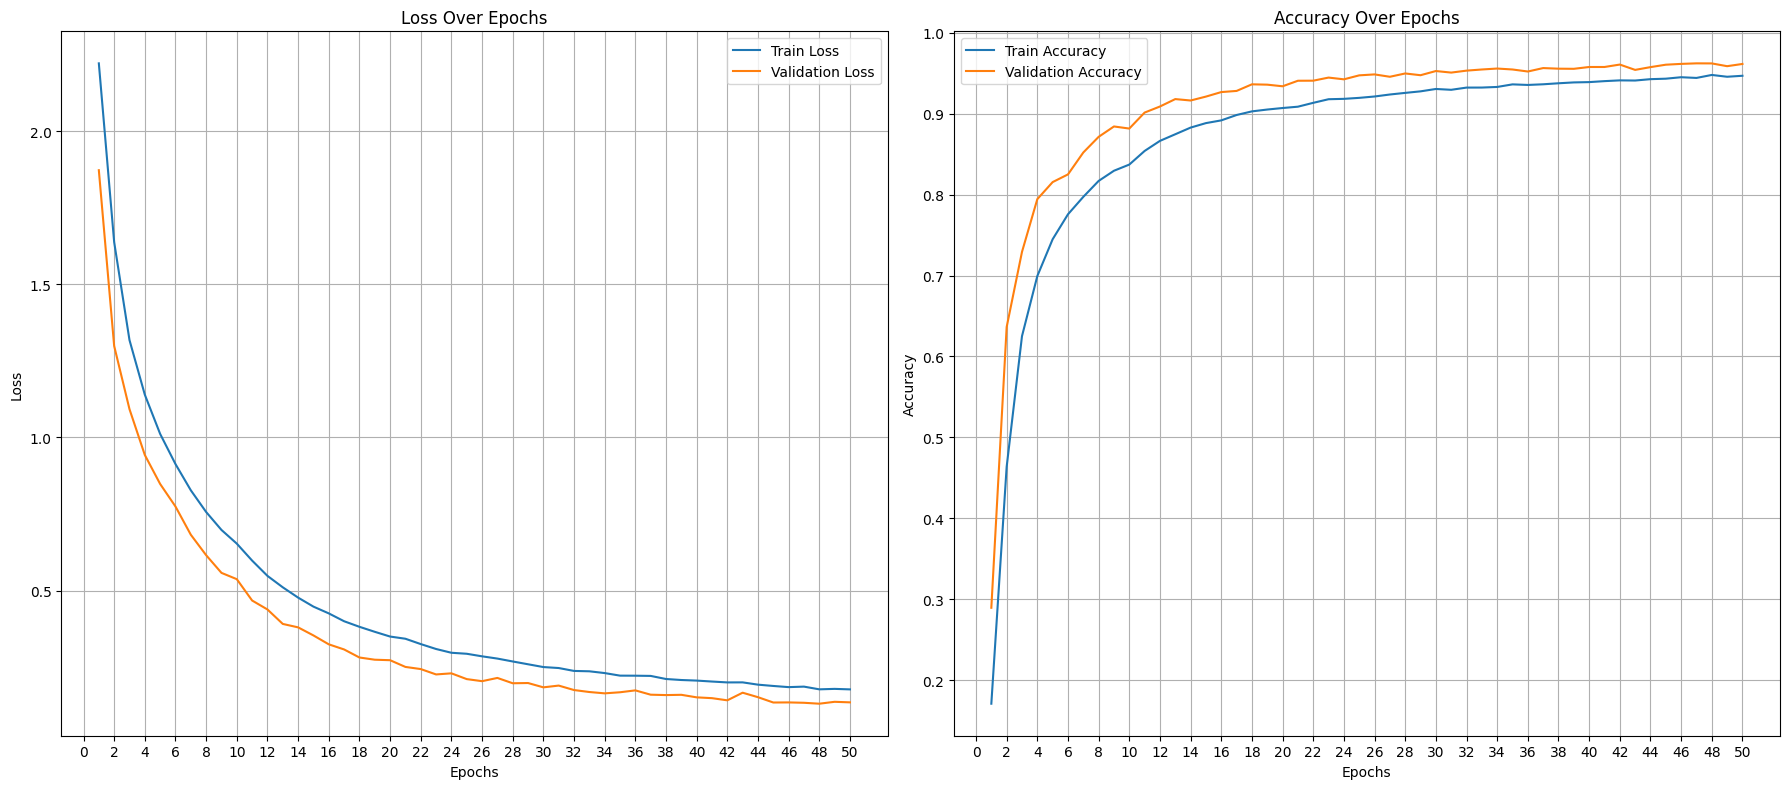

In [39]:
epochs_list=list(range(1, epochs+1))
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label="Train Loss")
plt.plot(epochs_list, val_losses, label="Validation Loss")
plt.xticks(ticks=list(range(0, epochs+1, 2)))
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accuracies, label="Train Accuracy")
plt.plot(epochs_list, val_accuracies, label="Validation Accuracy")
plt.xticks(ticks=list(range(0, epochs+1, 2)))
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [41]:
#Testing

test_labels=[]
test_preds=[]
test_running_loss=0
with torch.no_grad():
  for idx, (data, target) in enumerate(tqdm(test_dataloader, position=0, leave=True)):


    img=data.float().to(device)
    label=target.type(torch.uint8).to(device)
    y_pred=model2(img)
    y_pred_label=torch.argmax(y_pred, dim=1)

    test_labels.extend(label.cpu().detach())
    test_preds.extend(y_pred_label.cpu().detach())

    loss=criterion(y_pred, label)
    test_running_loss+=loss.item()

test_loss=test_running_loss / (idx+1)
test_accuracy=sum(1 for x, y in zip(test_preds, test_labels) if x==y) / len(test_labels)

print("-" * 30)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("-" * 30)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


------------------------------
Test Loss: 0.1341
Test Accuracy: 0.9624
------------------------------
